In [4]:
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from ldm.data.deepfashion import DeepFashionSMPL
from ldm.util import instantiate_from_config
from einops import rearrange
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy

import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from torchvision import transforms as T
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

from ldm.data.deepfashion_inshop import DeepFashionSample
from ldm.data.segm_utils import LipSegmenter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import pickle
import random


In [5]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.eval()
    return model

In [6]:
device = 'cuda:0'

# low res
CONFIG = 'models/upgpt/pt_256/config.yaml'
CKPT = 'models/upgpt/pt_256/upgpt.pt256.v1.ckpt'
#CKPT = 'logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt'
#CONFIG = 'logs/2023-01-31T02-39-11_inshop_lip_clip'
#CONFIG = 'configs/deepfashion/inshop_lip_clip.yaml'
#CKPT = 'logs/2023-02-27T01-37-45_lowres_bb/checkpoints/epoch=000002.ckpt'
#CONFIG ='logs/2023-02-27T01-37-45_lowres_bb/configs/2023-02-27T01-37-45-project.yaml'

#high res
#CKPT = 'logs/2023-02-26T00-00-00_highres/checkpoints/epoch=000011.ckpt'
#CONFIG = 'logs/2023-02-26T00-00-00_highres/configs/2023-02-25T23-56-53-project.yaml'

config = OmegaConf.load(CONFIG)
#config['data']['params']['test']['params']['data_file'] = 'deepfashion_map.csv'
# create clip image encoder


## Instantiate text and image encoder

In [7]:
clip_image_encoder = instantiate_from_config(config['model']['params']['extra_cond_stages']['style_cond']).to(device)
text_encoder_config = {'target': 'ldm.modules.encoders.modules.FrozenCLIPTextEmbedder', 
                       'params': {'normalize': False}}
clip_text_encoder = instantiate_from_config(text_encoder_config).to(device)
config['model']['params']['extra_cond_stages']['style_cond']['target'] = 'ldm.modules.poses.poses.DummyModel'
config['model']['params']['first_stage_config']['params']['ckpt_path'] = None
crop_size = config['model']['params']['crop_size']

In [8]:
model = load_model_from_config(config, f"{CKPT}").to(device)

Loading model from models/upgpt/pt_256/upgpt.pt256.v1.ckpt
Global Step: 49921
LatentDiffusion: Running in eps-prediction mode


/home/soon/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.7.layer_norm2.bias', 'vision_model.encoder.layers.22.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.4.mlp.fc2.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'vision_model.encoder.layers.9.layer_norm1.bias', 'vision_model.encoder.layers.14.self_attn.q_proj.weight', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_m

In [9]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
ds = DeepFashionSample(**config['data']['params']['test']['params'])

In [10]:
def generate(model, batch, steps=200, repeat=1):
    
    for k, v in batch.items():
        if type(v)==torch.Tensor:
            temp = batch[k].unsqueeze(0)
            repeat_list = [1]*len(temp.shape)
            repeat_list[0] = repeat
            batch[k] = temp.repeat(repeat_list).to(device)                        
        else:
            batch[k] = [batch[k]]*repeat
    
    with torch.no_grad():
        images = model.log_images(batch, ddim_steps=steps, use_ema=True,
                                  unconditional_guidance_scale=3.,
                                  unconditional_guidance_label=["txt"])
        
    for k in images:
        images[k] = images[k].detach().cpu()
        images[k] = torch.clamp(images[k], -1., 1.)
        images[k] = rearrange(images[k].numpy(),'b c h w -> b h w c') *0.5 + 0.5
    return images


def draw_styles(style_batch):
    
    #style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']

    denorm = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],  std = [ 1/0.226862954, 1/0.26130258, 1/0.27577711 ]),
                         T.Normalize(mean = [ -0.48145466, -0.4578275, -0.40821073], std = [ 1., 1., 1. ]),      ])
    rows, cols = 2, 4
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    for i, (name, style) in enumerate(zip(style_names[:-1], style_batch[:-1])):
        row = i//cols
        col = i%cols
        axs[row, col].imshow(T.ToPILImage()(denorm(style)))
        axs[row, col].set_title(name)
        axs[row, col].axis('off')
    plt.show()
            

In [11]:
import re

def convert_fname(long_name):
    gender = 'MEN' if long_name[7:10]  == 'MEN' else 'WOMEN'

    input_list = long_name.replace('fashion','').split('___')
    
    # Define a regular expression pattern to match the relevant parts of each input string
    if gender == 'MEN':
        pattern = r'MEN(\w+)id(\d+)_(\d)(\w+)'
    else:
        pattern = r'WOMEN(\w+)id(\d+)_(\d)(\w+)'
    # Use a list comprehension to extract the matching substrings from each input string, and format them into the desired output format
    output_list = [f'{gender}/{category}/id_{id_num[:8]}/{id_num[8:]}_{view_num}_{view_desc}' for (category, id_num, view_num, view_desc) in re.findall(pattern, ' '.join(input_list))]

    # Print the resulting list of formatted strings
    return output_list

#convert_fname('fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front')
convert_fname('fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side')

['WOMEN/Blouses_Shirts/id_00003115/01_7_additional',
 'WOMEN/Blouses_Shirts/id_00003115/01_2_side']

In [12]:
clip_transform = T.Compose([T.ToTensor(),
                           T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                                    std=(0.26862954, 0.26130258, 0.27577711))
                          ])

def get_empty_style():
    return clip_transform(np.zeros((224,224,3)))

In [13]:
def mix_style(s, w, mask=[]):
    style2id = dict(zip(style_names,[x for x in range(len(style_names))]))
    text_dict = dict(zip(style_names, ['' for _ in range(len(style_names))]))
    
    for m in mask:
        s[style2id[m]] = get_empty_style()
        
    with torch.no_grad():        
        for k, v in w.items():
            text_dict[k] = v
        texts = list(text_dict.values())
        text_emb = clip_text_encoder([texts])
        
        image_emb = clip_image_encoder(s.unsqueeze(0).to(device))

        for i, text in enumerate(texts):
            if text != '':                
                image_emb[0,i] = text_emb[0,i]
                
    return image_emb.squeeze(0)

#mix_style(dst_batch['styles'], text_prompt).shape

def get_coord(batch_mask):
    mask = batch_mask[0].cpu().numpy()
    mask[mask==-1] = 0
    x = np.nonzero(np.mean(mask,1))[0]
    xmin, xmax = x[0], x[-1]
    y = np.nonzero(np.mean(mask,0))[0]
    ymin, ymax = y[0], y[-1]

    return np.array([xmin, xmax, ymin, ymax])

def get_mask(mask, coord):
    device = mask.device
    xmin, xmax, ymin, ymax = coord
    new_mask = np.ones_like(mask.cpu().numpy())*(-1)
    new_mask[0,xmin:xmax+1, ymin:ymax+1] = -0.99215686
    #return new_mask
    return torch.tensor(new_mask).to(device)

def interp_mask(src_mask, dst_mask, alpha):    
    coord_1 = get_coord(src_mask)
    coord_2 = get_coord(dst_mask)

    coord = (alpha * coord_1 + (1 - alpha) * coord_2).astype(np.int32)
    print(coord)
    coord = np.array([ 0, 31,  7, 16])
    new_mask = get_mask(src_mask, coord)
    return new_mask


In [14]:
men = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='MEN' and  'full' in x]
women = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='WOM' and 'full' in x and 'Dres' in x]
len(women)

857

In [15]:
'''
result_root = 'logs/2023-02-03T22-46-00_inshop_lip_clip_recon_newname/results'
df = pd.read_csv(os.path.join(result_root, 'metrics_png.csv'))
#df['men'] = df['name'].map(lambda x: x[:10]=='fashionMEN')
#check_df = df[df['men']].sort_values(by=['SSIM'], ascending=False)
check_df = df.sort_values(by=['SSIM'], ascending=False)
'''

"\nresult_root = 'logs/2023-02-03T22-46-00_inshop_lip_clip_recon_newname/results'\ndf = pd.read_csv(os.path.join(result_root, 'metrics_png.csv'))\n#df['men'] = df['name'].map(lambda x: x[:10]=='fashionMEN')\n#check_df = df[df['men']].sort_values(by=['SSIM'], ascending=False)\ncheck_df = df.sort_values(by=['SSIM'], ascending=False)\n"

In [16]:
'''
start_idx = 5
for i in range(start_idx, start_idx+5):
    fname = check_df.iloc[i]['name']
    plt.figure(figsize=(10,10))
    plt.imshow(Image.open(os.path.join(result_root,'concats',fname)))
    plt.show()
    print(i)
'''

"\nstart_idx = 5\nfor i in range(start_idx, start_idx+5):\n    fname = check_df.iloc[i]['name']\n    plt.figure(figsize=(10,10))\n    plt.imshow(Image.open(os.path.join(result_root,'concats',fname)))\n    plt.show()\n    print(i)\n"

In [17]:
'''
select_id = 34
name_string = check_df.iloc[select_id]['name']
convert_fname(name_string.split('.')[0])
'''

"\nselect_id = 34\nname_string = check_df.iloc[select_id]['name']\nconvert_fname(name_string.split('.')[0])\n"

In [18]:
style_id = convert_fname('fashionWOMENShortsid0000478403_4full')[0]+'.jpg'
style_batch = ds[style_id]

style2_id = convert_fname('fashionWOMENSkirtsid0000698402_1front')[0]+'.jpg'
style2_batch = ds[style2_id]

WOMEN/Dresses/id_00006164/02_4_full WOMEN/Dresses/id_00007264/01_4_full
This female is wearing a tank tank top with graphic patterns and a medium shorts. The tank top is with cotton fabric and its neckline is round. The shorts are with cotton fabric and solid color patterns. This lady wears a ring.
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (6, 4, 32, 24), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██| 200/200 [00:08<00:00, 23.25it/s]


Plotting: Restored training weights


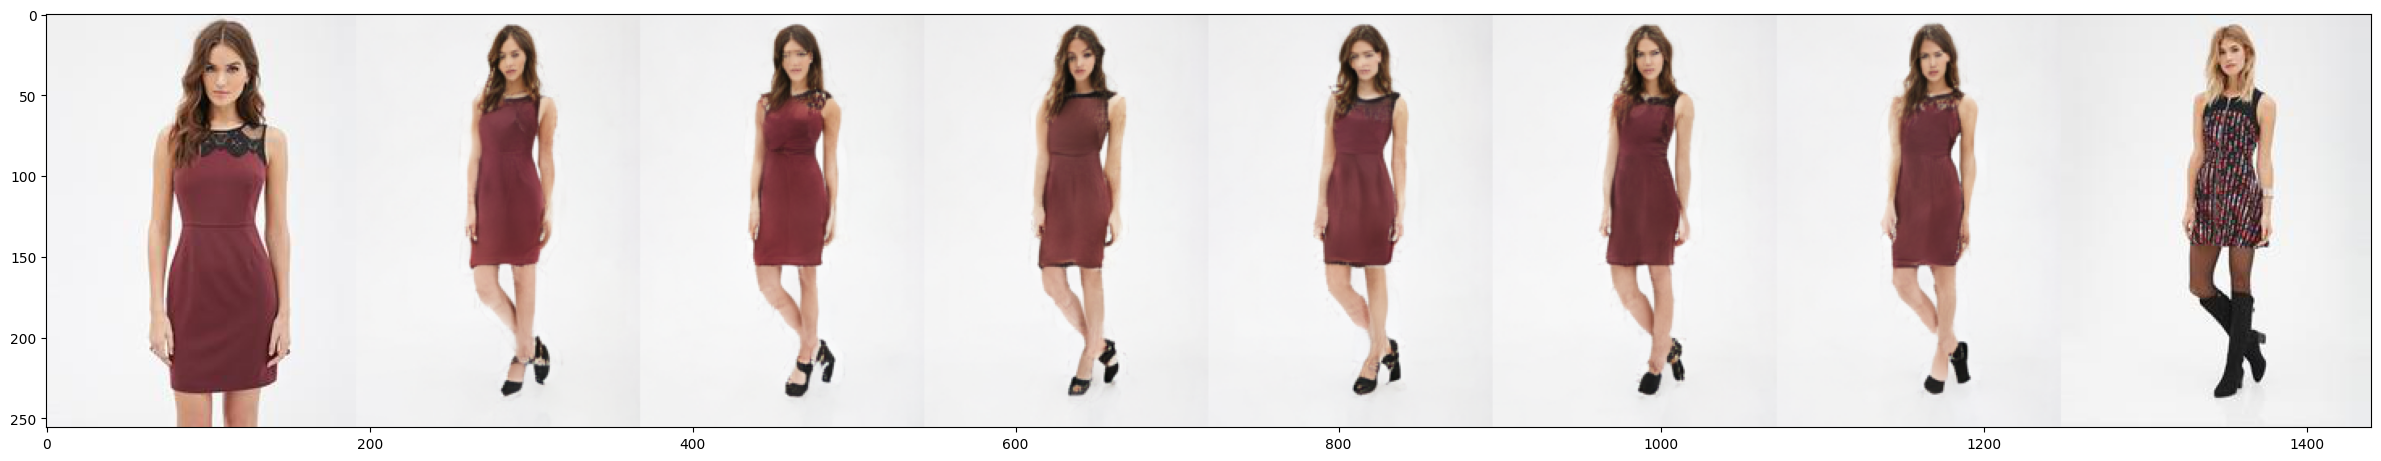

In [22]:
#src_id = 'WOMEN/Dresses/id_00006168/08_4_full'
#dst_id = 'MEN/Tees_Tanks/id_00007466/08_2_side'
#dst_id = random.choice(men)
dst_id = random.choice(women)
src_id = random.choice(women)
#dst_id = 'WOMEN-Dresses-id_00006868-02_4_full'.replace('-','/')
#dst_id = 'WOMEN-Jackets_Coats-id_00007450-02_1_front'.replace('-','/')
#src_id = dst_id
#name_string ='fashionWOMENJackets_Coatsid0000056302_4full___fashionWOMENJackets_Coatsid0000056302_4full'
#src_id, dst_id  = convert_fname(name_string.split('.')[0])
pose_interp = []

#for alpha in np.arange(1.0-0.13333,0.13333,-0.13333):
for alpha in [1.0]:
    src_batch = ds[src_id+'.jpg']
    dst_batch = ds[dst_id+'.jpg']
    
    src_image = np.uint8(((src_batch['image']+1)/2)*255)
    dst_image = np.uint8(((dst_batch['image']+1)/2)*255)
    src_smpl_image = Image.fromarray(np.uint8(((src_batch['smpl_image']+1)/2)*255))
    dst_smpl_image = Image.fromarray(np.uint8(((dst_batch['smpl_image']+1)/2)*255))
    print(src_id, dst_id)
    #dst_batch['txt'] = src_batch['txt']
    #src_batch['styles'] = dst_batch['styles']

    text_style = {#'face': "European white male",
                  #'hair':'short hair',
                  #'headwear': 'a red hat',
                  #'background':'brown flooring',
                  #'top':'a green short sleeve shirt in plaid pattern',
                  #'outer':'long sleeved jacket in orange leopard pattern',
                  #'bottom':'red dress in stripe pattern',
                  #'shoes':'black shoes',
                  #'accesories':''
                    }

    style_mask = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
    style_mask = []
    '''
    for transfer_id in [0,1]:
        src_batch['styles'][transfer_id] = style_batch['styles'][transfer_id]
    
    for transfer_id in [6]:
        src_batch['styles'][transfer_id] = style2_batch['styles'][transfer_id]
    '''    
    src_batch['styles'] = mix_style(src_batch['styles'], text_style, mask=style_mask)

    #dst_batch['smpl'][0,72:82] = src_batch['smpl'][0,72:82]
    src_batch['smpl'] = dst_batch['smpl']
    src_batch['person_mask'] = dst_batch['person_mask']
    
    ''' #pose interpolation 
    src_batch['smpl'] = alpha * src_batch['smpl'] + (1 - alpha) * dst_batch['smpl']
    src_batch['person_mask'] = interp_mask(src_batch['person_mask'], dst_batch['person_mask'], alpha)
    '''
    
    #src_batch['person_mask'] = dst_batch['person_mask']
    print(src_batch['txt'])
    #dst_batch['styles'] = clip_image_encoder(dst_batch['styles'].unsqueeze(0).to(device)).squeeze()
    #src_batch['txt'] = 'er T-shirt has short sleeves, cotton fabric and pure color patterns. The neckline of it is lapel. The trousers this lady wears is of long length. The trousers are with denim fabric and pure color patterns. The person also wears an outer clothing, with denim fabric and solid color patterns. There is a ring on her finger. There is an accessory on her wrist.'

    log = generate(model, src_batch, 200, repeat=6)
    samples = [np.array(T.CenterCrop(crop_size)(Image.fromarray(np.uint8(x*255)))) for x in log['samples']]
    plt.figure(figsize=(30,30))
    plt.imshow(np.hstack((src_image, np.hstack(samples), dst_image)))
    #sample = T.CenterCrop(size=(2*256, 2*176))(Image.fromarray(np.uint8(log['samples'][0]*255)))
    #sample.save(os.path.join(folder, j))
    #plt.figure(figsize=(10,10))
    #concat = np.hstack((src_image, np.array(sample), dst_image))
    #pose_interp.append(np.array(sample))
    #plt.imshow(concat)
    #plt.axis('off')
    #plt.show()

#concat = np.hstack((src_image, np.hstack(pose_interp), dst_image))
#plt.figure(figsize=(10,10))
#plt.imshow(concat)
#plt.axis('off')
#plt.show()


In [36]:
folder = './figures/512/'+src_id.replace('/','-')+'_female'
os.makedirs(folder,exist_ok=True)
smpl_image = src_batch['smpl_image'][0].cpu().numpy()*0.5+0.5
smpl_image = Image.fromarray((smpl_image*255).astype(np.uint8))
smpl_image = T.CenterCrop((512,256))(smpl_image.resize((192*2,256*2)))
smpl_image.save(os.path.join(folder,f'smpl.jpg'))
with open(os.path.join(folder, 'caption.txt'), 'w') as f:
    f.write(src_batch['txt'][0])


offset = 0
for i, sample in enumerate(samples):
    path = os.path.join(folder,f'{i+offset}.jpg')
    #assert not os.path.isfile(path)
    Image.fromarray(sample).save(path)


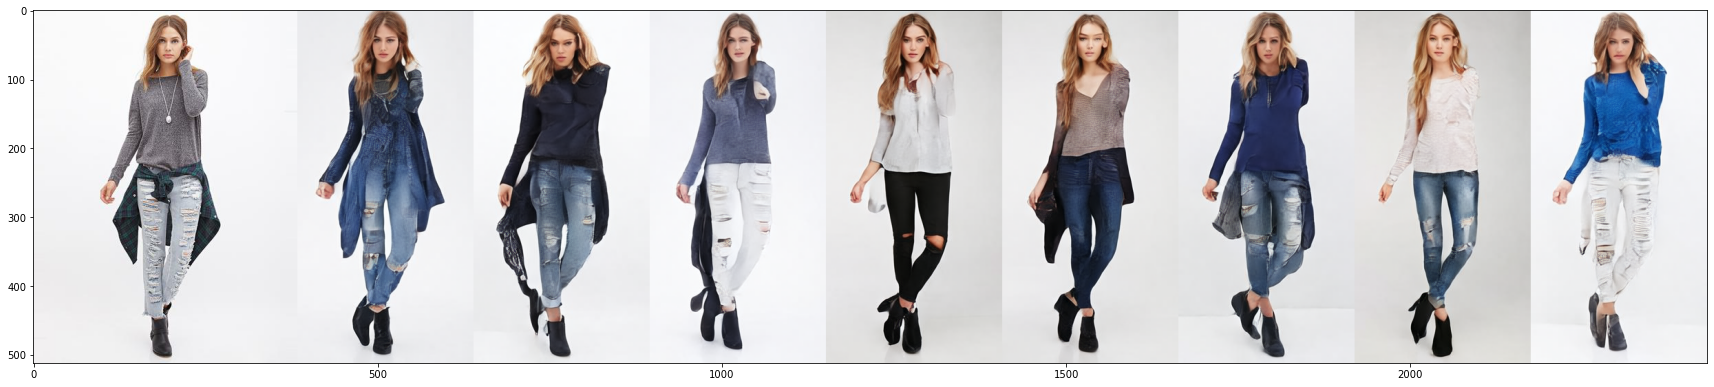

In [128]:
plt.figure(figsize=(30,30))  
plt.imshow(np.hstack((src_image, np.hstack(samples))))

In [608]:
folder = "./figures/512/"
os.makedirs(folder,exist_ok=True)
path = os.path.join(folder,name_string)
#assert not os.path.isfile(path)
Image.fromarray(pose_interp[0]).save(path)

In [21]:
folder = "./figures/interp/1/"
os.makedirs(folder, exist_ok=True)
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

In [22]:
#for i in range(len(pose_interp)):
#    Image.fromarray(pose_interp[i]).save(os.path.join(folder,f'{i}.jpg'))

In [23]:
folder = "./figures/interp/0/"
os.makedirs(folder,exist_ok=True)
name = 'panda'
path = os.path.join(folder, name+'.png')
assert not os.path.isfile(path)
sample.save(path)

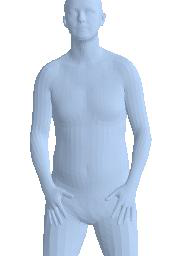

In [24]:
src_smpl_image = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(((src_batch['smpl_image'][0].cpu().numpy()+1)/2)*255)))
src_smpl_image

In [25]:
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

src_smpl_image.save(os.path.join(folder,'src_smpl.png'))

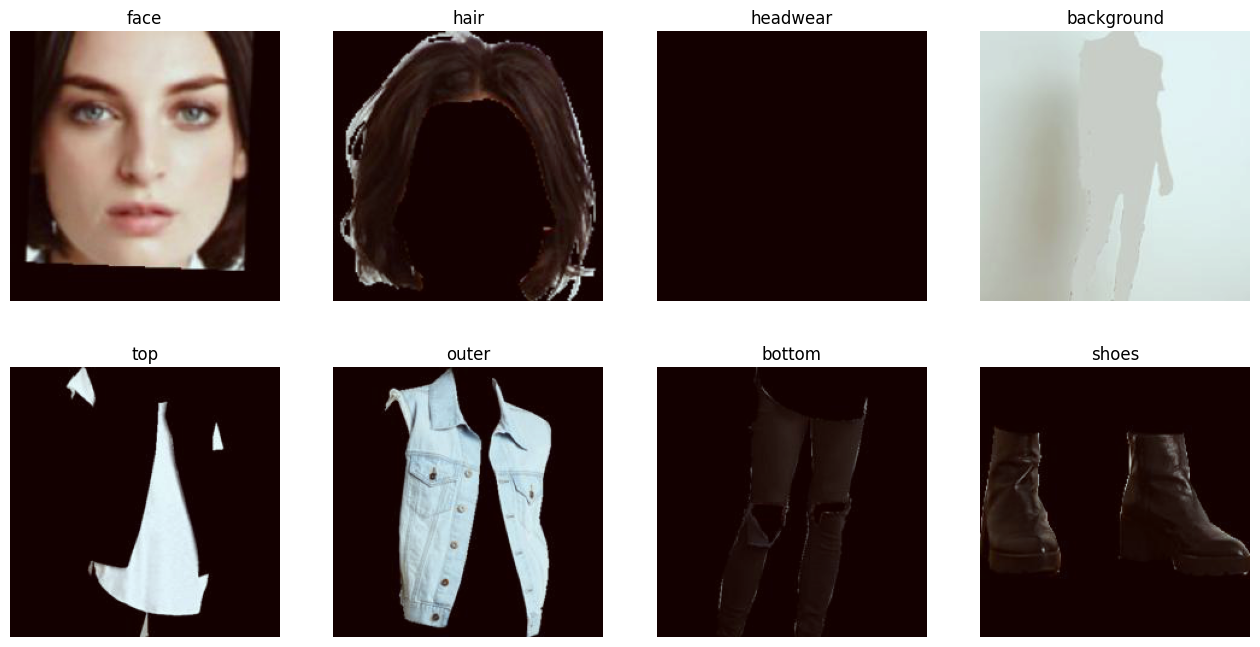

In [21]:
draw_styles(dst_batch['styles'])